In [4]:
# Load and inspect HDF5 data structure
import h5py
import numpy as np
import yaml
import os

# Path to the dataset directory
dataset_dir = "/home/iwsatlas1/jrenusch/master_thesis/tracking/data/train_setPU200_processed_h5"

# Load metadata
metadata_file = os.path.join(dataset_dir, 'metadata.yaml')
with open(metadata_file, 'r') as f:
    metadata = yaml.safe_load(f)

print("="*60)
print("HDF5 DATA STRUCTURE INSPECTION")
print("="*60)

# Get the first HDF5 file to inspect
first_chunk = metadata['event_mapping']['chunk_summary'][0]
print(first_chunk   )
h5_file_path = os.path.join(dataset_dir, first_chunk['h5_file'])

print(f"Inspecting: {h5_file_path}")
print(f"Expected events: {first_chunk['event_count']}")

with h5py.File(h5_file_path, 'r') as f:
    print(f"\nFile-level attributes:")
    for key, value in f.attrs.items():
        print(f"  {key}: {value}")
    
    print(f"\nGroups in file: {list(f.keys())}")
    print(f"Number of event groups: {len([k for k in f.keys() if k.startswith('event_')])}")
    
    # Inspect first few events
    for i in range(min(3, len([k for k in f.keys() if k.startswith('event_')]))):
        event_group = f[f'event_{i}']
        print(f"\nEvent {i}:")
        print(f"  Attributes: {dict(event_group.attrs)}")
        print(f"  Datasets: {list(event_group.keys())}")
        
        if 'hits' in event_group:
            hits_data = event_group['hits'][:]
            print(f"  Hits shape: {hits_data.shape}")
            print(f"  Hits dtype: {hits_data.dtype}")
            
        if 'tracks' in event_group:
            tracks_data = event_group['tracks'][:]
            print(f"  Tracks shape: {tracks_data.shape}")
            print(f"  Tracks dtype: {tracks_data.dtype}")

HDF5 DATA STRUCTURE INSPECTION
{'h5_file': 'data/events_0to1000.h5', 'event_count': 1000, 'start_event': 0, 'end_event': 1000}
Inspecting: /home/iwsatlas1/jrenusch/master_thesis/tracking/data/train_setPU200_processed_h5/data/events_0to1000.h5
Expected events: 1000

File-level attributes:
  chunk_end_event: 1000
  chunk_event_count: 1000
  chunk_start_event: 0
  hit_feature_names: ['spacePoint_PositionX' 'spacePoint_PositionY' 'spacePoint_PositionZ'
 'spacePoint_covXX' 'spacePoint_covXY' 'spacePoint_covYX'
 'spacePoint_covYY' 'spacePoint_channel' 'spacePoint_driftR'
 'spacePoint_layer' 'spacePoint_stationPhi' 'spacePoint_stationEta'
 'spacePoint_technology' 'spacePoint_truthLink']
  track_feature_names: ['truthMuon_pt' 'truthMuon_eta' 'truthMuon_phi' 'truthMuon_q']

Groups in file: ['event_0', 'event_1', 'event_10', 'event_100', 'event_101', 'event_102', 'event_103', 'event_104', 'event_105', 'event_106', 'event_107', 'event_108', 'event_109', 'event_11', 'event_110', 'event_111', 'even

In [6]:
# Function to load and display specific events
def load_event_from_hdf5(dataset_dir, event_index):
    """Load a specific event by its index in the dataset."""
    
    # Load index arrays
    global_ids = np.load(os.path.join(dataset_dir, 'event_global_ids.npy'))
    file_indices = np.load(os.path.join(dataset_dir, 'event_file_indices.npy'))
    row_indices = np.load(os.path.join(dataset_dir, 'event_row_indices.npy'))
    chunk_info = np.load(os.path.join(dataset_dir, 'chunk_info.npy'), allow_pickle=True)
    
    if event_index >= len(global_ids):
        print(f"Event index {event_index} is out of range. Max index: {len(global_ids)-1}")
        return None, None
    
    # Get file and row information
    global_id = global_ids[event_index]
    file_idx = file_indices[event_index]
    row_idx = row_indices[event_index]
    
    # Get chunk info
    chunk = chunk_info[file_idx]
    h5_file_path = os.path.join(dataset_dir, chunk['h5_file'])
    
    print(f"Loading event {event_index} (global ID: {global_id})")
    print(f"From file: {chunk['h5_file']}, event group: event_{row_idx}")
    
    # Load the event data
    with h5py.File(h5_file_path, 'r') as f:
        event_group = f[f'event_{row_idx}']
        
        # Load hits and tracks
        hits = event_group['hits'][:]
        tracks = event_group['tracks'][:]
        
        # Get feature names from file attributes
        hit_features = list(f.attrs['hit_feature_names'])
        track_features = list(f.attrs['track_feature_names'])
        
        print(f"Event attributes: {dict(event_group.attrs)}")
        
        return {
            'hits': hits,
            'tracks': tracks,
            'hit_features': hit_features,
            'track_features': track_features,
            'global_id': global_id,
            'num_hits': hits.shape[0],
            'num_tracks': tracks.shape[0]
        }, event_group.attrs

# Test the function
print("="*60)
print("LOADING SPECIFIC EVENTS")
print("="*60)

for event_idx in [0, 5, 10]:
    event_data, event_attrs = load_event_from_hdf5(dataset_dir, event_idx)
    
    if event_data:
        print(f"\nEvent {event_idx} details:")
        print(f"  Global ID: {event_data['global_id']}")
        print(f"  Number of hits: {event_data['num_hits']}")
        print(f"  Number of tracks: {event_data['num_tracks']}")
        print(f"  Hit features: {event_data['hit_features']}")
        print(f"  Track features: {event_data['track_features']}")
        
        # Show some sample hit data
        if event_data['num_hits'] > 0:
            print(f"  First 3 hits (first 5 features):")
            for i in range(min(3, event_data['num_hits'])):
                hit_values = event_data['hits'][i, :]
                feature_names = event_data['hit_features'][:]
                print(f"    Hit {i}: {dict(zip(feature_names, hit_values))}")
        
        # Show track data
        if event_data['num_tracks'] > 0:
            print(f"  Track data:")
            for i in range(min(3, event_data['num_tracks'])):
                track_values = event_data['tracks'][i, :]
                track_dict = dict(zip(event_data['track_features'], track_values))
                print(f"    Track {i}: {track_dict}")

LOADING SPECIFIC EVENTS
Loading event 0 (global ID: 0)
From file: data/events_0to1000.h5, event group: event_0
Event attributes: {'global_event_id': 0, 'num_hits': 2836, 'num_tracks': 2}

Event 0 details:
  Global ID: 0
  Number of hits: 2836
  Number of tracks: 2
  Hit features: ['spacePoint_PositionX', 'spacePoint_PositionY', 'spacePoint_PositionZ', 'spacePoint_covXX', 'spacePoint_covXY', 'spacePoint_covYX', 'spacePoint_covYY', 'spacePoint_channel', 'spacePoint_driftR', 'spacePoint_layer', 'spacePoint_stationPhi', 'spacePoint_stationEta', 'spacePoint_technology', 'spacePoint_truthLink']
  Track features: ['truthMuon_pt', 'truthMuon_eta', 'truthMuon_phi', 'truthMuon_q']
  First 3 hits (first 5 features):
    Hit 0: {'spacePoint_PositionX': 406.65665, 'spacePoint_PositionY': 4276.154, 'spacePoint_PositionZ': 810.75, 'spacePoint_covXX': 212.81267, 'spacePoint_covXY': -3.2568877, 'spacePoint_covYX': -5.3832603, 'spacePoint_covYY': 130.89346, 'spacePoint_channel': 12.0, 'spacePoint_driftR

In [7]:
# Verify data integrity across multiple files
print("="*60)
print("DATA INTEGRITY VERIFICATION")
print("="*60)

# Load all index arrays
global_ids = np.load(os.path.join(dataset_dir, 'event_global_ids.npy'))
file_indices = np.load(os.path.join(dataset_dir, 'event_file_indices.npy'))
row_indices = np.load(os.path.join(dataset_dir, 'event_row_indices.npy'))
num_hits = np.load(os.path.join(dataset_dir, 'event_num_hits.npy'))
num_tracks = np.load(os.path.join(dataset_dir, 'event_num_tracks.npy'))
chunk_info = np.load(os.path.join(dataset_dir, 'chunk_info.npy'), allow_pickle=True)

print(f"Index array consistency check:")
print(f"  All arrays same length: {len(set([len(global_ids), len(file_indices), len(row_indices), len(num_hits), len(num_tracks)])) == 1}")
print(f"  Global IDs are sequential: {np.array_equal(global_ids, np.arange(len(global_ids)))}")

# Verify each HDF5 file
print(f"\nVerifying {len(chunk_info)} HDF5 files:")
total_events_verified = 0

for chunk_idx, chunk in enumerate(chunk_info):
    h5_file_path = os.path.join(dataset_dir, chunk['h5_file'])
    
    if os.path.exists(h5_file_path):
        with h5py.File(h5_file_path, 'r') as f:
            # Count events in this file
            event_groups = [k for k in f.keys() if k.startswith('event_')]
            events_in_file = len(event_groups)
            
            # Check file attributes
            file_start = f.attrs['chunk_start_event']
            file_end = f.attrs['chunk_end_event']
            file_count = f.attrs['chunk_event_count']
            
            # Verify against metadata
            expected_count = chunk['count']
            
            print(f"  Chunk {chunk_idx}: {chunk['h5_file']}")
            print(f"    Events in file: {events_in_file}")
            print(f"    Expected events: {expected_count}")
            print(f"    File attrs - start: {file_start}, end: {file_end}, count: {file_count}")
            print(f"    Consistent: {events_in_file == expected_count == file_count}")
            
            total_events_verified += events_in_file
    else:
        print(f"  Chunk {chunk_idx}: FILE NOT FOUND - {chunk['h5_file']}")

print(f"\nTotal events verified: {total_events_verified}")
print(f"Expected total events: {len(global_ids)}")
print(f"Verification successful: {total_events_verified == len(global_ids)}")

DATA INTEGRITY VERIFICATION
Index array consistency check:
  All arrays same length: True
  Global IDs are sequential: True

Verifying 2 HDF5 files:
  Chunk 0: data/events_0to1000.h5
    Events in file: 1000
    Expected events: 1000
    File attrs - start: 0, end: 1000, count: 1000
    Consistent: True
  Chunk 1: data/events_1000to1254.h5
    Events in file: 254
    Expected events: 254
    File attrs - start: 1000, end: 1254, count: 254
    Consistent: True

Total events verified: 1254
Expected total events: 1254
Verification successful: True


DATASET STATISTICS AND VISUALIZATION


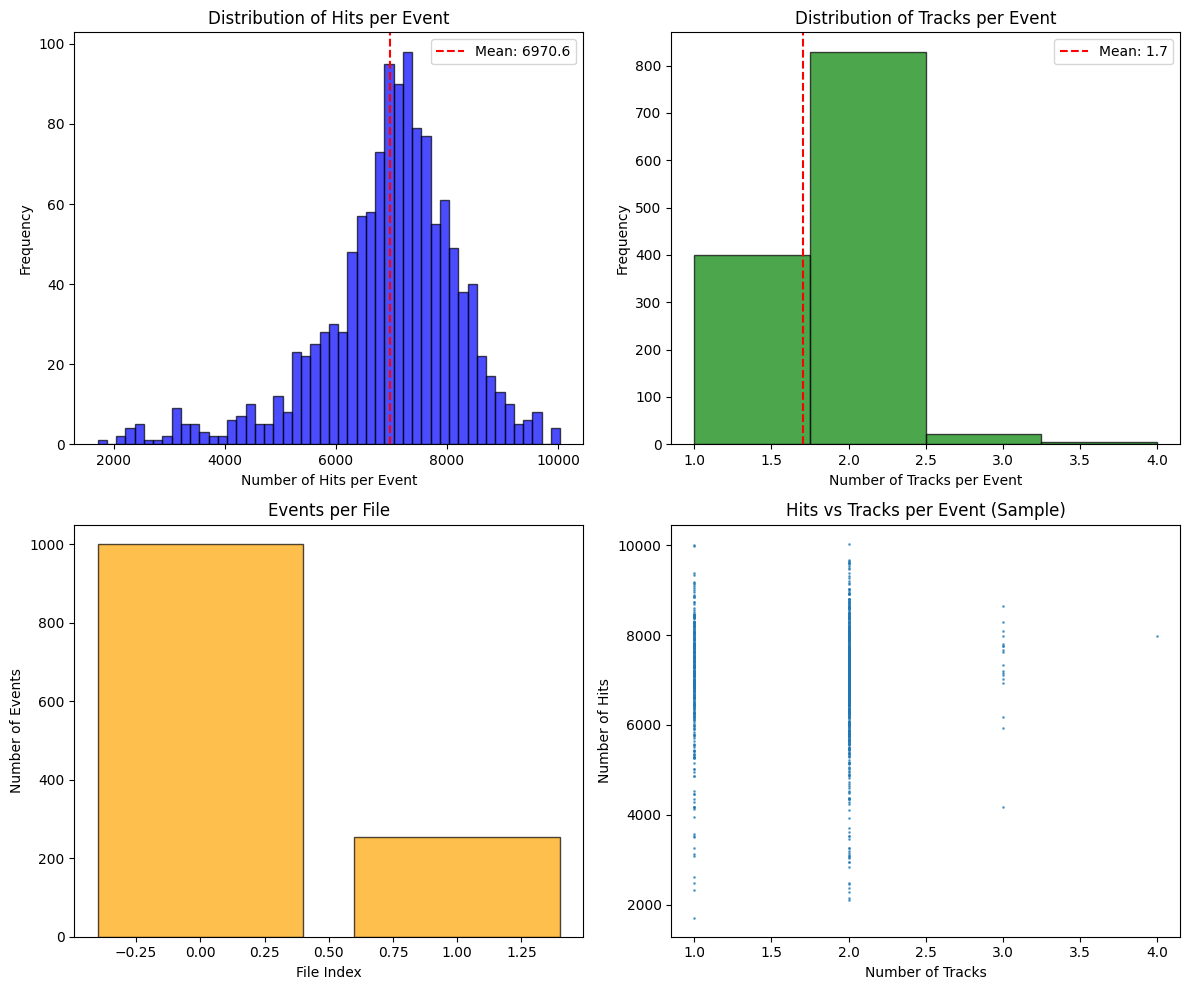


Detailed Statistics:
Hits per event:
  Mean: 6970.59
  Median: 7125.50
  Std: 1260.21
  Min: 1706
  Max: 10035

Tracks per event:
  Mean: 1.71
  Median: 2.00
  Std: 0.51
  Min: 1
  Max: 4

File distribution:
  data/events_0to1000.h5: 1000 events
  data/events_1000to1254.h5: 254 events


In [8]:
# Visualize dataset statistics
import matplotlib.pyplot as plt

print("="*60)
print("DATASET STATISTICS AND VISUALIZATION")
print("="*60)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Distribution of hits per event
axes[0, 0].hist(num_hits, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_xlabel('Number of Hits per Event')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Hits per Event')
axes[0, 0].axvline(np.mean(num_hits), color='red', linestyle='--', label=f'Mean: {np.mean(num_hits):.1f}')
axes[0, 0].legend()

# 2. Distribution of tracks per event
axes[0, 1].hist(num_tracks, bins=max(1, int(np.max(num_tracks))), alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Number of Tracks per Event')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Tracks per Event')
axes[0, 1].axvline(np.mean(num_tracks), color='red', linestyle='--', label=f'Mean: {np.mean(num_tracks):.1f}')
axes[0, 1].legend()

# 3. Events per file
unique_files, counts = np.unique(file_indices, return_counts=True)
axes[1, 0].bar(unique_files, counts, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('File Index')
axes[1, 0].set_ylabel('Number of Events')
axes[1, 0].set_title('Events per File')

# 4. Scatter: hits vs tracks per event
sample_indices = np.random.choice(len(num_hits), size=min(1000, len(num_hits)), replace=False)
axes[1, 1].scatter(num_tracks[sample_indices], num_hits[sample_indices], alpha=0.6, s=1)
axes[1, 1].set_xlabel('Number of Tracks')
axes[1, 1].set_ylabel('Number of Hits')
axes[1, 1].set_title('Hits vs Tracks per Event (Sample)')

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nDetailed Statistics:")
print(f"Hits per event:")
print(f"  Mean: {np.mean(num_hits):.2f}")
print(f"  Median: {np.median(num_hits):.2f}")
print(f"  Std: {np.std(num_hits):.2f}")
print(f"  Min: {np.min(num_hits)}")
print(f"  Max: {np.max(num_hits)}")

print(f"\nTracks per event:")
print(f"  Mean: {np.mean(num_tracks):.2f}")
print(f"  Median: {np.median(num_tracks):.2f}")
print(f"  Std: {np.std(num_tracks):.2f}")
print(f"  Min: {np.min(num_tracks)}")
print(f"  Max: {np.max(num_tracks)}")

print(f"\nFile distribution:")
for file_idx, count in zip(unique_files, counts):
    chunk = chunk_info[file_idx]
    print(f"  {chunk['h5_file']}: {count} events")